In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 100000)

In [2]:
df = pd.read_excel('/Users/zaferavci/Documents/GitHub/Miuul-CaseStudy-1/Miuul-Case-Study/ctk/ctk_melted (1).xlsx')

In [3]:
df.columns = [col.lower() for col in df.columns]

In [4]:
df['order_date__c'].min(), df['order_date__c'].max()

(Timestamp('2017-01-16 00:00:00'), Timestamp('2025-03-14 00:00:00'))

In [5]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42612 entries, 0 to 42611
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   customer_account__c    42612 non-null  object        
 1   customer_name__c       42612 non-null  object        
 2   facility_type__c       42134 non-null  object        
 3   id                     42612 non-null  object        
 4   order no               42612 non-null  int64         
 5   order_date__c          42612 non-null  datetime64[ns]
 6   order_year__c          42612 non-null  int64         
 7   pb_pieces__c           42612 non-null  int64         
 8   shipping_city__c       42612 non-null  object        
 9   shipping_state__c      42612 non-null  object        
 10  shipping_zip_code__c   42612 non-null  object        
 11  total_order_pieces__c  42612 non-null  int64         
 12  products               42612 non-null  object        
 13  q

In [6]:
 #df.to_csv('mergedata.csv', index=False, encoding='utf-8')

In [7]:
df.describe().T  

,count,mean,min,25%,50%,75%,max,std
order no,42612.000,2000987.426,1021.000,529275.000,535243.000,540885.250,18000071430.000,154000503.230
order_date__c,42612,2023-01-19 20:35:08.701774080,2017-01-16 00:00:00,2022-02-15 18:00:00,2023-05-17 00:00:00,2024-05-19 00:00:00,2025-03-14 00:00:00,NaN
order_year__c,42612.000,2022.571,2017.000,2022.000,2023.000,2024.000,2025.000,1.560
pb_pieces__c,42612.000,81.256,0.000,0.000,0.000,50.000,15000.000,396.037
total_order_pieces__c,42612.000,520.808,0.000,125.000,238.500,500.000,47350.000,1372.703
quantity,42612.000,2.455,1.000,1.000,1.000,2.000,1760.000,11.163
pieces,42612.000,108.459,0.000,25.000,50.000,100.000,44000.000,374.753
size,42612.000,53.130,0.000,10.000,25.000,50.000,3750.000,70.289


In [8]:
df.describe(include='O').T  

,count,unique,top,freq
customer_account__c,42612,7156,001f4000015h1KeAAI,332
customer_name__c,42612,8493,003f400001JzDt0AAF,138
facility_type__c,42134,10,OBGYN Clinic,9513
id,42612,12674,a10Pd000000VHJ7IAO,24
shipping_city__c,42612,2887,Columbus,480
shipping_state__c,42612,51,FL,7807
shipping_zip_code__c,42612,4190,50314,134
products,42612,87,CTK03_English_Brochures_Pack_Size,8259


FACİLİTY TYPE MİSSİNG VALUE MOD İLE DOLDURULDU

In [9]:
# En sık geçen değeri (mod) bulalım
mod_value = df['facility_type__c'].mode()[0]

# Boşlukları bu değerle dolduralım
df['facility_type__c'] = df['facility_type__c'].fillna(mod_value)

KOLONLARI KATEGORİK TARİH VE SAYISAL OLARAK AYIRMA

In [10]:
# İlk olarak tüm object ve category kolonlarını al
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# ID gibi analizde kullanmak istemediğimiz kolonları çıkar
id_cols = ['customer_account__c', 'customer_name__c', 'id']
cat_cols = [col for col in cat_cols if col not in id_cols]

# Sayısal kolonlar
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Tarih kolonları
date_cols = df.select_dtypes(include=['datetime']).columns.tolist()

# Sonuçları görelim
print("Kategorik Değişkenler:", cat_cols)
print("Sayısal Değişkenler:", num_cols)
print("Tarih Değişkenleri:", date_cols)

Kategorik Değişkenler: ['facility_type__c', 'shipping_city__c', 'shipping_state__c', 'shipping_zip_code__c', 'products']
Sayısal Değişkenler: ['order no', 'order_year__c', 'pb_pieces__c', 'total_order_pieces__c', 'quantity', 'pieces', 'size']
Tarih Değişkenleri: ['order_date__c']


In [11]:
# [1] Her tesis türü için özet metrikler
facility_summary = df.groupby('facility_type__c').agg(
    total_orders=('order no', 'nunique'),
    total_quantity=('pieces', 'sum'),
    unique_customers=('customer_account__c', 'nunique')
).reset_index()

facility_summary['orders_per_customer'] = facility_summary['total_quantity'] / facility_summary['unique_customers']


In [12]:
# [2] Her müşteri için kaç sipariş verdiğini say
repeat_df = df.groupby(['customer_account__c', 'facility_type__c'])['order no'].nunique().reset_index(name='order_count')

# [3] Her facility type için tekrar eden müşteri oranı
repeat_df['is_repeat'] = repeat_df['order_count'] > 1
repeat_rate_by_facility = repeat_df.groupby('facility_type__c')['is_repeat'].mean().reset_index(name='repeat_rate')

# [4] Özet tabloya dahil et
facility_summary = facility_summary.merge(repeat_rate_by_facility, on='facility_type__c')


In [13]:
# [5] En çok sipariş alanlardan en sadık müşterilere sıralı tablo
facility_summary_sorted = facility_summary.sort_values(by='total_orders', ascending=False)
display(facility_summary_sorted)
facility_summary_sorted.to_excel("denem.xlsx")

,facility_type__c,total_orders,total_quantity,unique_customers,orders_per_customer,repeat_rate
4,OBGYN Clinic,3434,1162326,1945,597.597,0.332
5,Other,2487,1198850,1790,669.749,0.179
7,Public Health Agency,2291,877335,1285,682.751,0.356
0,Birthing Hospital,1579,573943,924,621.150,0.350
2,Home Visitor,1341,346144,940,368.238,0.240
1,Family Practice Clinic,516,98191,373,263.247,0.212
9,WIC Clinic,482,195884,325,602.720,0.258
6,Pregnancy Resource Center,364,132162,273,484.110,0.179
3,Non-traditional Practice,170,35870,162,221.420,0.037
8,Urgent Care,4,955,4,238.750,0.000


 Yüksek Potansiyele Sahip Gruplar:
OBGYN Clinic ve Public Health Agency hem hacim hem de sadakat açısından güçlü segmentler.

Özellikle Public Health tesisleri, en yüksek tekrar oranına sahip (%35.6) → sadakat programları için ideal başlangıç noktası.

 Riskli ama Kazanılabilir Gruplar:
Other segmenti çok yüksek hacme sahip olmasına rağmen sadakati düşük (%18) → tekrar siparişe teşvik edilmeli.

WIC Clinic, Pregnancy Resource Center gibi gruplarda sipariş hacmi orta seviyede ama müşteriler tekrar sipariş vermiyor → kurtarma kampanyaları önerilir.

 Verimsiz veya Yeniden Değerlendirilmeli:
Non-traditional Practice ve Urgent Care, hem hacim hem de tekrar oranı açısından çok zayıf (%3.7 ve %0) → bu gruplar pazarlama hedefinden çıkarılabilir ya da yapısal analiz yapılmalı.

Genel Öneri:
Her tesis tipi aynı değil. Bu yüzden stratejiler de özelleştirilmeli:
Bazıları korunmalı, bazıları büyütülmeli, bazıları ise azaltılmalı.

Aşağıda detaylı grafikleri var.

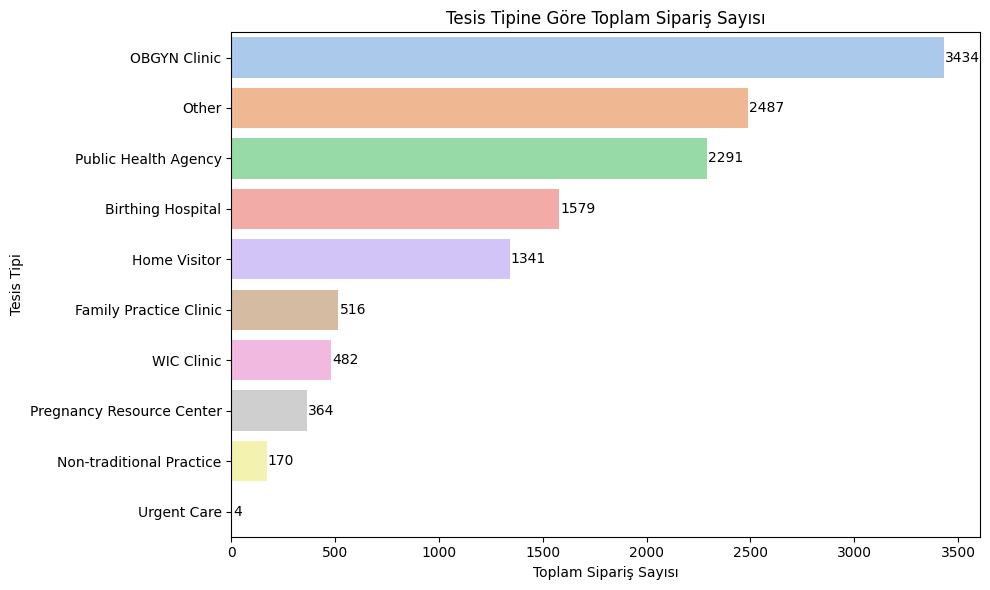

In [14]:
plt.figure(figsize=(10, 6))
bar1 = sns.barplot(
    data=facility_summary_sorted,
    x='total_orders',
    y='facility_type__c',
    palette='pastel'
)
plt.title('Tesis Tipine Göre Toplam Sipariş Sayısı')
plt.xlabel('Toplam Sipariş Sayısı')
plt.ylabel('Tesis Tipi')

# Etiket ekle
for p in bar1.patches:
    width = p.get_width()
    plt.text(width + 5, p.get_y() + p.get_height() / 2,
             f'{int(width)}', va='center')

plt.tight_layout()
plt.savefig("tesisType.png", dpi=300)
plt.show()


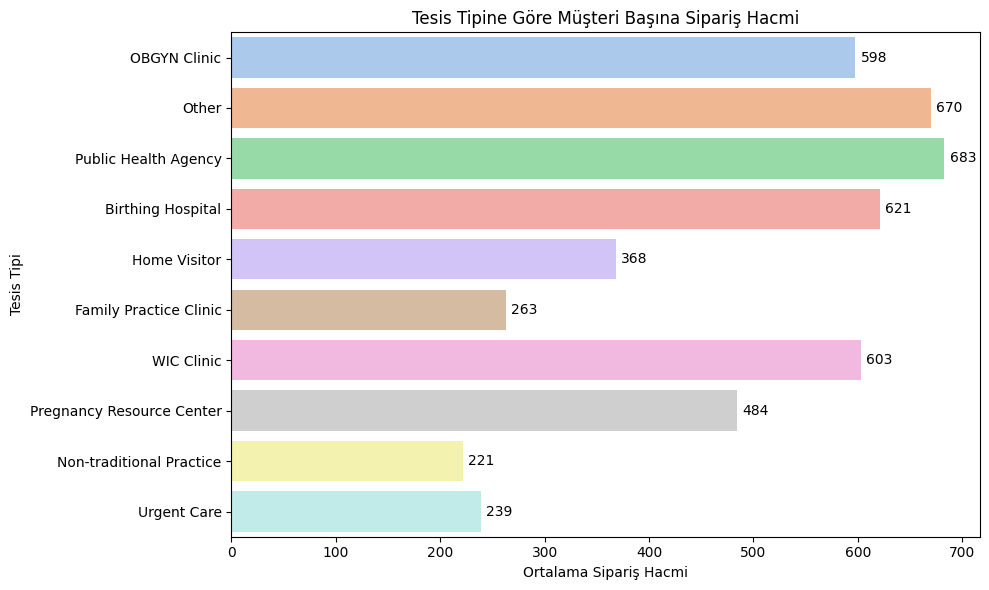

In [15]:
plt.figure(figsize=(10, 6))
bar2 = sns.barplot(
    data=facility_summary_sorted,
    x='orders_per_customer',
    y='facility_type__c',
    palette='pastel'
)
plt.title('Tesis Tipine Göre Müşteri Başına Sipariş Hacmi')
plt.xlabel('Ortalama Sipariş Hacmi')
plt.ylabel('Tesis Tipi')

# Etiket ekle
for p in bar2.patches:
    width = p.get_width()
    plt.text(width + 5, p.get_y() + p.get_height() / 2,
             f'{width:.0f}', va='center')

plt.tight_layout()
plt.savefig("tesisTypeCustomer.png", dpi=300)
plt.show()


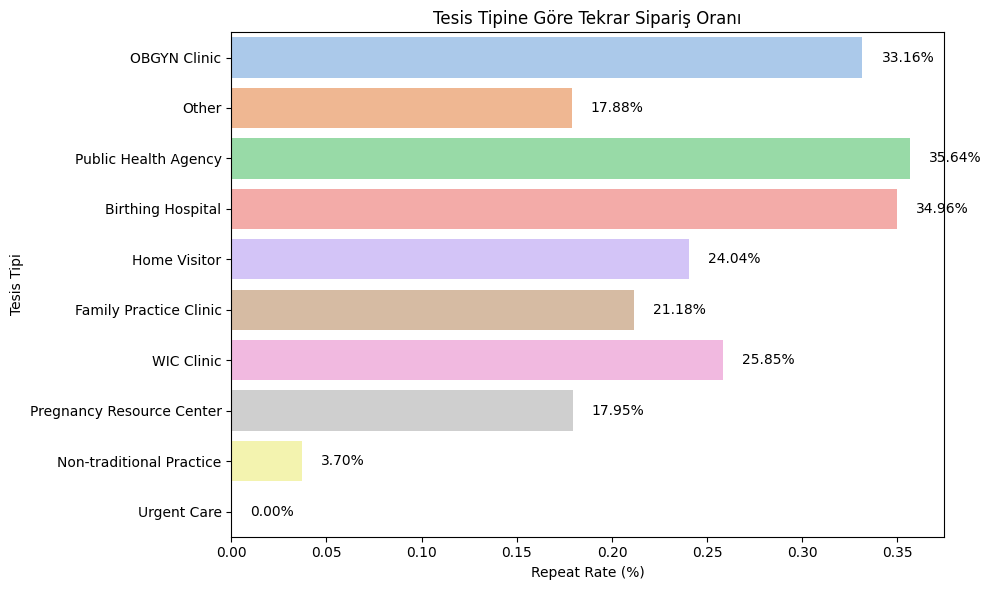

In [16]:
plt.figure(figsize=(10, 6))
bar3 = sns.barplot(
    data=facility_summary_sorted,
    x='repeat_rate',
    y='facility_type__c',
    palette='pastel'
)
plt.title('Tesis Tipine Göre Tekrar Sipariş Oranı')
plt.xlabel('Repeat Rate (%)')
plt.ylabel('Tesis Tipi')

# Etiket ekle
for p in bar3.patches:
    width = p.get_width()
    plt.text(width + 0.01, p.get_y() + p.get_height() / 2,
             f'{width:.2%}', va='center')

plt.tight_layout()
plt.savefig("tesisTypeTekrar.png", dpi=300)
plt.show()


Her tesis tipi farklı davranış sergiliyor. Örneğin OBGYN Clinic ve Public Health Agency yüksek hacim ve siparişe sahipken, Non-traditional Practice gibi gruplar düşük hacim ve sadakat oranı gösteriyor. Bu verilerle tesis tipi bazında özelleştirilmiş yaklaşımlar geliştirilebilir.”

In [17]:
# [2] Her müşteri için kaç sipariş verdiğini say
repeat_df = df.groupby(['customer_account__c', 'facility_type__c'])['order no'].nunique().reset_index(name='order_count')

# [3] Her facility type için tekrar eden müşteri oranı
repeat_df['is_repeat'] = repeat_df['order_count'] > 1
repeat_rate_by_facility = repeat_df.groupby('facility_type__c')['is_repeat'].mean().reset_index(name='repeat_rate')

# [4] Özet tabloya dahil et
facility_summary = facility_summary.merge(repeat_rate_by_facility, on='facility_type__c')


In [18]:
df.head()# Tarihi formatla
df['order_date__c'] = pd.to_datetime(df['order_date__c'], errors='coerce')

# Kategori ve dil sütunlarını oluştur
df['product_category'] = df['products'].apply(categorize_product)
df['language'] = df['products'].apply(detect_language)

# Yıl bilgisi
df['order_year'] = df['order_date__c'].dt.year

NameError: name 'categorize_product' is not defined

In [19]:
# [2.1] order_date sütunundan yıl bilgisi çıkar
df['order_date__c'] = pd.to_datetime(df['order_date__c'], errors='coerce')
df['order_year'] = df['order_date__c'].dt.year


In [20]:
# [2.2] Yıllara göre benzersiz sipariş sayısı
orders_by_year = df.groupby('order_year')['order no'].nunique().reset_index(name='total_orders')

# [2.3] Sipariş sayısına göre yıllık büyüme oranı
orders_by_year['growth_rate_orders'] = orders_by_year['total_orders'].pct_change().round(3)

orders_by_year.to_excel("orders_by_year.xlsx")


In [21]:
# [2.4] Yıllara göre toplam ürün hacmi (adet)
pieces_by_year = df.groupby('order_year')['pieces'].sum().reset_index(name='total_pieces')

# [2.5] Hacme göre yıllık büyüme oranı
pieces_by_year['growth_rate_pieces'] = pieces_by_year['total_pieces'].pct_change().round(3)

pieces_by_year


,order_year,total_pieces,growth_rate_pieces
0,2017,3875,NaN
1,2018,1350,-0.652
2,2019,298600,220.185
3,2020,427170,0.431
4,2021,563340,0.319
5,2022,922874,0.638
6,2023,1093908,0.185
7,2024,1128870,0.032
8,2025,181673,-0.839


In [22]:
#  Yıla Göre Sipariş Başına Ortalama Ürün Hacmi Tablosu
df['order_year'] = df['order_date__c'].dt.year

# Her yıl için sipariş bazlı ortalama hacim
avg_by_year = (
    df.groupby(['order_year', 'order no'])['pieces'].sum()
    .groupby('order_year')
    .mean()
    .reset_index(name='avg_pieces_per_order')
)

display(avg_by_year)


,order_year,avg_pieces_per_order
0,2017,430.556
1,2018,150.000
2,2019,368.187
3,2020,452.032
4,2021,419.152
5,2022,370.038
6,2023,364.272
7,2024,330.465
8,2025,286.550


In [23]:
# [2.6] Büyümeleri tek tabloda birleştir
yearly_summary = pd.merge(orders_by_year, pieces_by_year, on='order_year')
yearly_summary


,order_year,total_orders,growth_rate_orders,total_pieces,growth_rate_pieces
0,2017,9,NaN,3875,NaN
1,2018,9,0.000,1350,-0.652
2,2019,811,89.111,298600,220.185
3,2020,945,0.165,427170,0.431
4,2021,1344,0.422,563340,0.319
5,2022,2494,0.856,922874,0.638
6,2023,3003,0.204,1093908,0.185
7,2024,3416,0.138,1128870,0.032
8,2025,634,-0.814,181673,-0.839


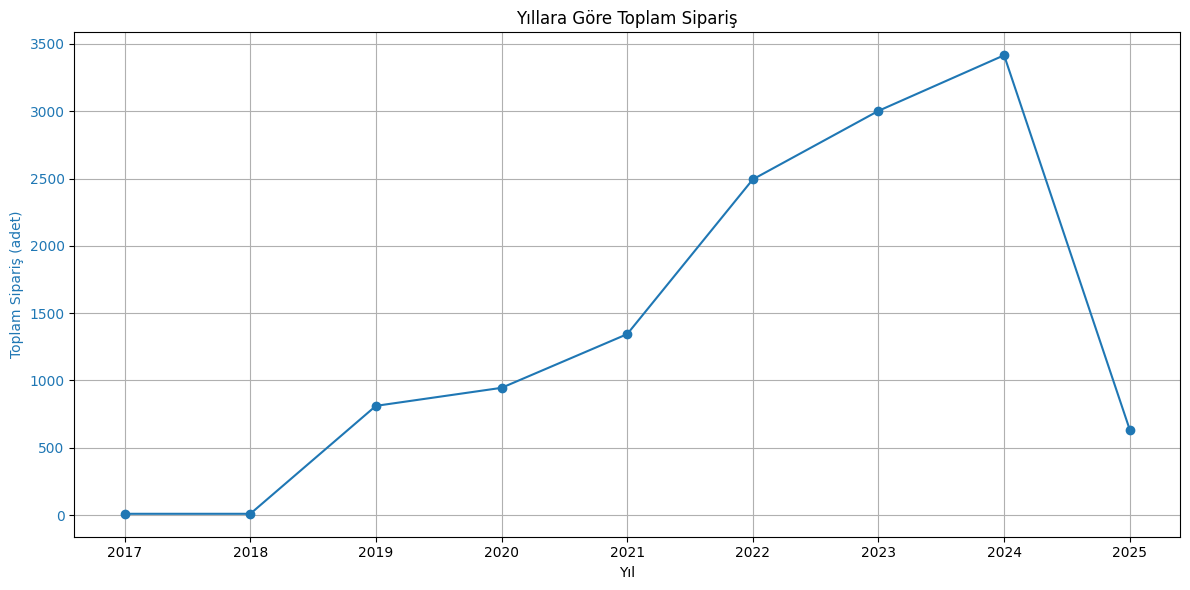

In [24]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 6))

# Birinci y-ekseni: toplam sipariş adedi
color = 'tab:blue'
ax1.set_xlabel('Yıl')
ax1.set_ylabel('Toplam Sipariş (adet)', color=color)
ax1.plot(yearly_summary['order_year'], yearly_summary['total_orders'], color=color, marker='o', label='Toplam Sipariş (adet)')
ax1.tick_params(axis='y', labelcolor=color)


# Başlık ve gösterim
plt.title('Yıllara Göre Toplam Sipariş')
fig.tight_layout()
plt.grid(True)
plt.savefig("yerasumsales.png", dpi=300)
plt.show()


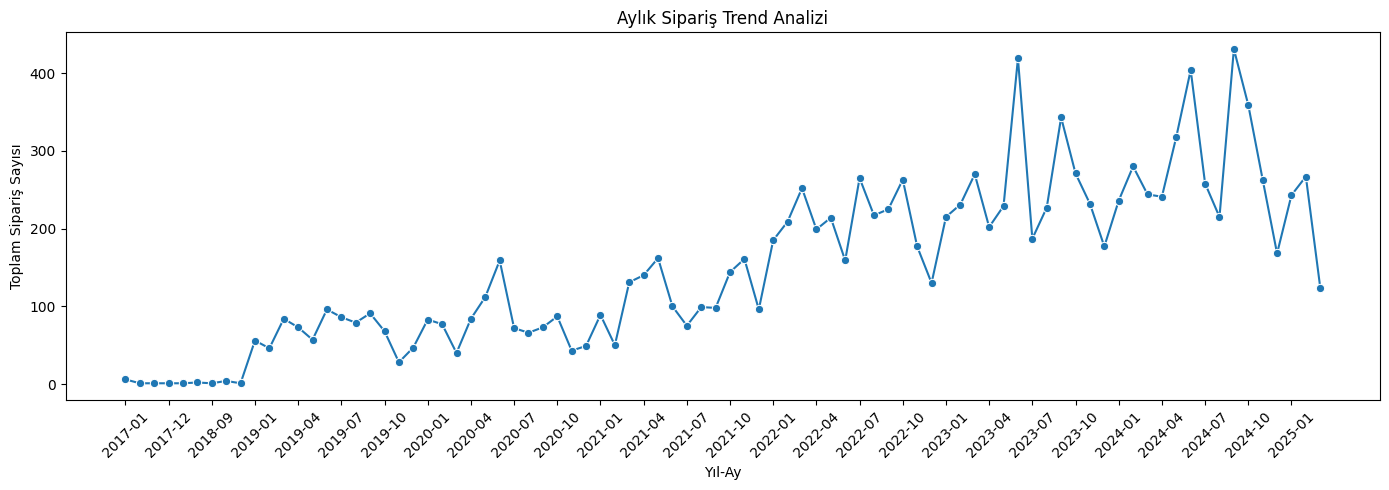

In [25]:
# Sipariş tarihini datetime formatına çevir
df['order_date__c'] = pd.to_datetime(df['order_date__c'], errors='coerce')

# Yıl-Ay bazlı toplam sipariş sayısı
df['year_month'] = df['order_date__c'].dt.to_period('M')
monthly_trend = df.groupby('year_month').agg(total_orders=('order no', 'nunique')).reset_index()

# Dönem string'e çevrilip grafik çizilir
monthly_trend['year_month'] = monthly_trend['year_month'].astype(str)

plt.figure(figsize=(14, 5))
sns.lineplot(data=monthly_trend, x='year_month', y='total_orders', marker='o')

# Her 3. etiketi göster
xticks_to_show = monthly_trend['year_month'].tolist()[::3]
plt.xticks(ticks=range(0, len(monthly_trend['year_month']), 3), labels=xticks_to_show, rotation=45)

plt.title("Aylık Sipariş Trend Analizi")
plt.xlabel("Yıl-Ay")
plt.ylabel("Toplam Sipariş Sayısı")
plt.tight_layout()
plt.savefig("monthsumsales.png", dpi=300)
plt.show()


####################

“2019’dan itibaren sipariş hacmi dramatik şekilde artmış, 2023 ve 2024’te zirveye ulaşmıştır. Ancak 2025'te hem sipariş adedinde hem de hacimde ciddi bir düşüş yaşanmış gibi gözüksede aslında 2025 yılı verisi henüz tüm yılı kapsamıyor. Bu nedenle 2025'e ait veriler, yıl tamamlandığında tekrar analiz edilmelidir. Şu aşamada bu düşüş, veri eksikliğinden kaynaklı geçici bir durum da olabilir.”

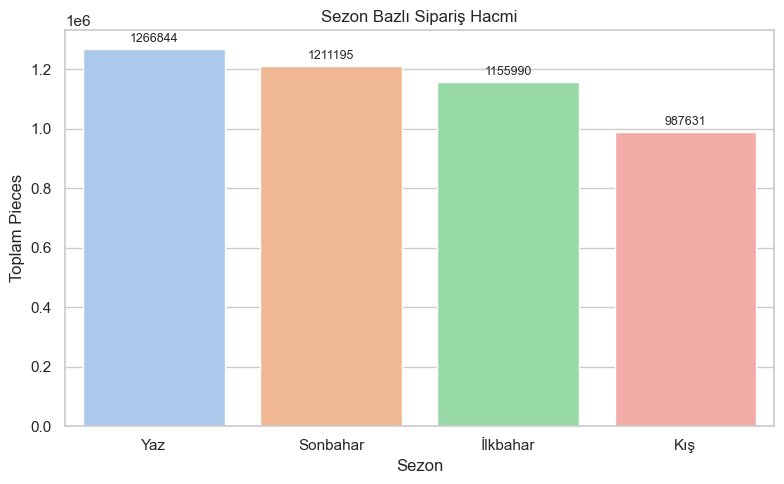

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Sipariş tarihinden ay bilgisini çıkar
df['order_month'] = df['order_date__c'].dt.month

# 2. Aydan sezona dönüştürme fonksiyonu
def assign_season(month):
    if month in [12, 1, 2]:
        return 'Kış'
    elif month in [3, 4, 5]:
        return 'İlkbahar'
    elif month in [6, 7, 8]:
        return 'Yaz'
    else:
        return 'Sonbahar'

# 3. Sezon sütununu oluştur
df['season'] = df['order_month'].apply(assign_season)

# 4. Sezon bazlı toplam sipariş hacmini hesapla
season_summary = (
    df.groupby('season')['pieces']
    .sum()
    .reset_index()
    .sort_values(by='pieces', ascending=False)
)

# 5. Grafikle göster
plt.figure(figsize=(8, 5))
sns.set(style="whitegrid")
bar = sns.barplot(data=season_summary, x='season', y='pieces', palette='pastel')

# 6. Etiketleri üstte göster (tam sayı)
for container in bar.containers:
    bar.bar_label(container, fmt='%.0f', padding=3, fontsize=9)

plt.title('Sezon Bazlı Sipariş Hacmi')
plt.xlabel('Sezon')
plt.ylabel('Toplam Pieces')
plt.tight_layout()
plt.savefig("seasonsumsales.png", dpi=300)
plt.show()


SEGMENT BAZLI ANALİZ

In [27]:
# [3.1] Tesis bazlı toplam sipariş, toplam ürün ve müşteri sayısı
df_segment = df.groupby('facility_type__c').agg(
    total_orders=('order no', 'nunique'),
    total_quantity=('pieces', 'sum'),
    unique_customers=('customer_account__c', 'nunique')
).reset_index()

# [3.2] Müşteri başına sipariş hacmi
df_segment['orders_per_customer'] = df_segment['total_quantity'] / df_segment['unique_customers']


In [28]:
# [3.3] Ortalama sipariş adedi ve ortalama hacim
x_mean = df_segment['orders_per_customer'].mean()
y_mean = df_segment['total_orders'].mean()


In [29]:
# [3.4] Segment fonksiyonu
def classify_segment(row):
    if row['orders_per_customer'] >= x_mean and row['total_orders'] >= y_mean:
        return 'Yüksek Hacim & Yüksek Sipariş (Altın Segment)'
    elif row['orders_per_customer'] >= x_mean:
        return 'Yüksek Hacim & Düşük Sipariş (Potansiyel)'
    elif row['total_orders'] >= y_mean:
        return 'Düşük Hacim & Yüksek Sipariş (Tutarsız)'
    else:
        return 'Düşük Hacim & Düşük Sipariş (Düşük Öncelik)'

# [3.5] Segment etiketi ekle
df_segment['segment_kategorisi'] = df_segment.apply(classify_segment, axis=1)

df_segment[['facility_type__c', 'total_orders', 'orders_per_customer', 'segment_kategorisi']]


,facility_type__c,total_orders,orders_per_customer,segment_kategorisi
0,Birthing Hospital,1579,621.150,Yüksek Hacim & Yüksek Sipariş (Altın Segment)
1,Family Practice Clinic,516,263.247,Düşük Hacim & Düşük Sipariş (Düşük Öncelik)
2,Home Visitor,1341,368.238,Düşük Hacim & Yüksek Sipariş (Tutarsız)
3,Non-traditional Practice,170,221.420,Düşük Hacim & Düşük Sipariş (Düşük Öncelik)
4,OBGYN Clinic,3434,597.597,Yüksek Hacim & Yüksek Sipariş (Altın Segment)
5,Other,2487,669.749,Yüksek Hacim & Yüksek Sipariş (Altın Segment)
6,Pregnancy Resource Center,364,484.110,Yüksek Hacim & Düşük Sipariş (Potansiyel)
7,Public Health Agency,2291,682.751,Yüksek Hacim & Yüksek Sipariş (Altın Segment)
8,Urgent Care,4,238.750,Düşük Hacim & Düşük Sipariş (Düşük Öncelik)
9,WIC Clinic,482,602.720,Yüksek Hacim & Düşük Sipariş (Potansiyel)


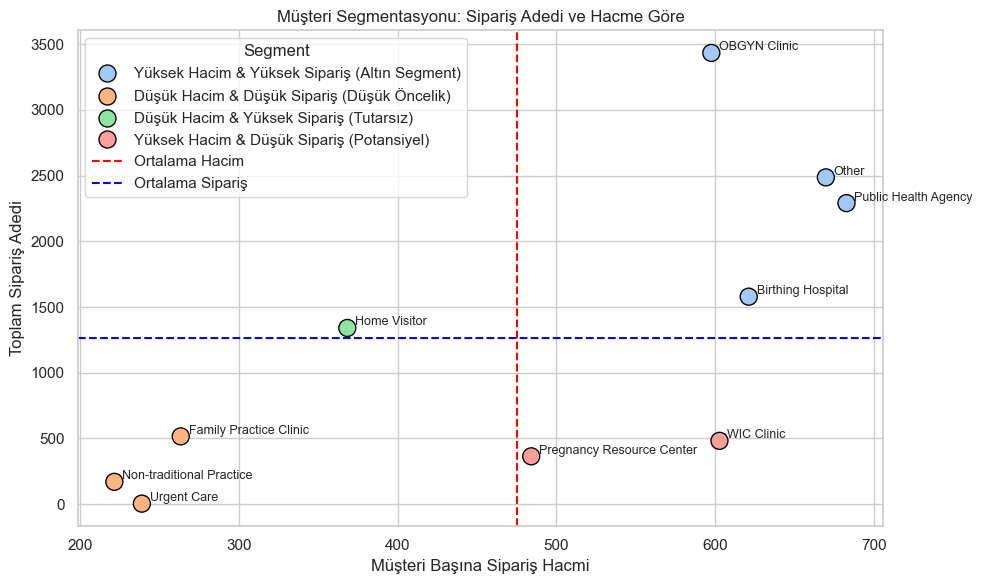

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.set(style='whitegrid')

# [3.6] Segmentlere göre scatter plot
scatter = sns.scatterplot(
    data=df_segment,
    x='orders_per_customer',
    y='total_orders',
    hue='segment_kategorisi',
    s=150,
    palette='pastel',
    edgecolor='black'
)

# Ortalamaları gösteren çizgiler
plt.axvline(x=x_mean, color='red', linestyle='--', label='Ortalama Hacim')
plt.axhline(y=y_mean, color='blue', linestyle='--', label='Ortalama Sipariş')

# Etiket ekle
for idx, row in df_segment.iterrows():
    plt.text(row['orders_per_customer'] + 5, row['total_orders'] + 20, row['facility_type__c'], fontsize=9)

plt.title('Müşteri Segmentasyonu: Sipariş Adedi ve Hacme Göre')
plt.xlabel('Müşteri Başına Sipariş Hacmi')
plt.ylabel('Toplam Sipariş Adedi')
plt.legend(title='Segment')
plt.tight_layout()
plt.savefig("segment.png", dpi=300)
plt.show()


Altın Segment (Yüksek Hacim & Yüksek Sipariş):
OBGYN Clinic, Public Health Agency, Birthing Hospital, Other tesisleri bu kategoride.

Bu gruplar, sistemin bel kemiği. Siparişleri hem sık hem de büyük hacimli.

Strateji: Sadakat programı, kişisel temsilci atamaları ve özel kampanyalarla bu gruplar elde tutulmalı.

Potansiyel Segment (Yüksek Hacim & Düşük Sipariş):
Pregnancy Resource Center ve WIC Clinic bu kategoride.

Az sipariş veriyorlar ama verdiklerinde hacim yüksek → “sessiz ama değerli” müşteriler.

Strateji: Bu grup tekrar siparişe teşvik edilmeli (örneğin: otomatik sipariş, hatırlatma e-postaları).

Tutarsız Segment (Düşük Hacim & Yüksek Sipariş):
Home Visitor tek başına bu grupta.

Sık sipariş veriyor ama hacmi düşük — yüksek işlem maliyeti riski taşıyor.

Strateji: Siparişleri konsolide etmeye teşvik edilmeli (örneğin: paket önerileri).

Düşük Öncelik Segmenti (Düşük Hacim & Düşük Sipariş):
Family Practice Clinic, Non-traditional Practice, Urgent Care bu segmentte.

Sipariş sayısı az, hacim de küçük → yatırım geri dönüşü düşük.

Strateji: Bu gruplara düşük maliyetli temas stratejileri uygulanmalı veya kapsam dışı bırakılabilir.

Genel Sunum Yorumu:
“Tesisleri tekil analiz etmek yerine, sipariş davranışlarına göre segmente etmek; stratejiyi hedefli hale getiriyor. Kaynaklarımızı Altın Segment’e yoğunlaştırıp, Potansiyel Segment’te büyümeyi tetikleyebiliriz. Düşük değerli segmentlerde ise maliyet-etkinlik değerlendirmesi yapılmalı.”

 Segmentasyonu Nasıl Oluşturduk? (Hoca kesin sorar :))
Segmentleri oluştururken iki temel metriği kullandık:

Toplam Sipariş Sayısı: Tesisin sistemle ne kadar sık etkileşime geçtiğini gösterir.

Müşteri Başına Ortalama Sipariş Hacmi: Tesise bağlı her müşterinin ortalama olarak ne kadar ürün sipariş ettiğini ölçer.

Bu iki metriğin ortalaması alınarak, her tesis tipi bu eşiklere göre dört segmente ayrıldı:

Altın Segment: Hem sık hem de yüksek hacimli sipariş verenler

Potansiyel Segment: Az sipariş verir ama hacmi yüksektir

Tutarsız Segment: Sık sipariş verir ama hacmi düşüktür

Düşük Öncelik Segmenti: Hem az hem küçük sipariş verir

Bu segmentasyon sayesinde tesisleri sadece isimlerine göre değil, gerçek sipariş davranışlarına göre sınıflandırarak hedefli stratejiler geliştirebiliyoruz.

In [31]:
# [4.1] Her müşteri için yıl, tesis türü ve segment bilgisi
df_yearly = df[['order_year', 'facility_type__c', 'customer_account__c']].drop_duplicates()
df_yearly = df_yearly.merge(df_segment[['facility_type__c', 'segment_kategorisi']], on='facility_type__c', how='left')


In [32]:
# [4.2] Hangi segmentte hangi yıl kimler vardı?
customer_by_year_segment = df_yearly.groupby(['order_year', 'segment_kategorisi'])['customer_account__c'].unique().reset_index()


In [33]:
# [4.3] Yıllar arası churn hesaplaması
results = []
years = sorted(df_yearly['order_year'].dropna().unique())

for i in range(len(years)-1):
    y1, y2 = years[i], years[i+1]
    df_y1 = customer_by_year_segment[customer_by_year_segment['order_year'] == y1]
    df_y2 = customer_by_year_segment[customer_by_year_segment['order_year'] == y2]

    for segment in df_y1['segment_kategorisi'].unique():
        set_y1 = set(df_y1[df_y1['segment_kategorisi'] == segment]['customer_account__c'].explode())
        set_y2 = set(df_y2[df_y2['segment_kategorisi'] == segment]['customer_account__c'].explode()) if segment in df_y2['segment_kategorisi'].values else set()
        churned = set_y1 - set_y2
        churn_rate = len(churned) / len(set_y1) if set_y1 else 0
        results.append({
            'segment_kategorisi': segment,
            'yil': f"{y1}→{y2}",
            'musteri_sayisi_y1': len(set_y1),
            'tekrar_siparis_y2': len(set_y1 & set_y2),
            'churn_edilen': len(churned),
            'churn_orani': round(churn_rate, 3)
        })

churn_df = pd.DataFrame(results)
display(churn_df)


,segment_kategorisi,yil,musteri_sayisi_y1,tekrar_siparis_y2,churn_edilen,churn_orani
0,Yüksek Hacim & Yüksek Sipariş (Altın Segment),2017→2018,6,1,5,0.833
1,Düşük Hacim & Düşük Sipariş (Düşük Öncelik),2018→2019,1,0,1,1.000
2,Yüksek Hacim & Yüksek Sipariş (Altın Segment),2018→2019,8,2,6,0.750
3,Düşük Hacim & Düşük Sipariş (Düşük Öncelik),2019→2020,62,5,57,0.919
4,Yüksek Hacim & Yüksek Sipariş (Altın Segment),2019→2020,562,121,441,0.785
5,Düşük Hacim & Düşük Sipariş (Düşük Öncelik),2020→2021,68,9,59,0.868
6,Yüksek Hacim & Yüksek Sipariş (Altın Segment),2020→2021,703,163,540,0.768
7,Düşük Hacim & Düşük Sipariş (Düşük Öncelik),2021→2022,59,13,46,0.780
8,Düşük Hacim & Yüksek Sipariş (Tutarsız),2021→2022,124,17,107,0.863
9,Yüksek Hacim & Düşük Sipariş (Potansiyel),2021→2022,65,14,51,0.785


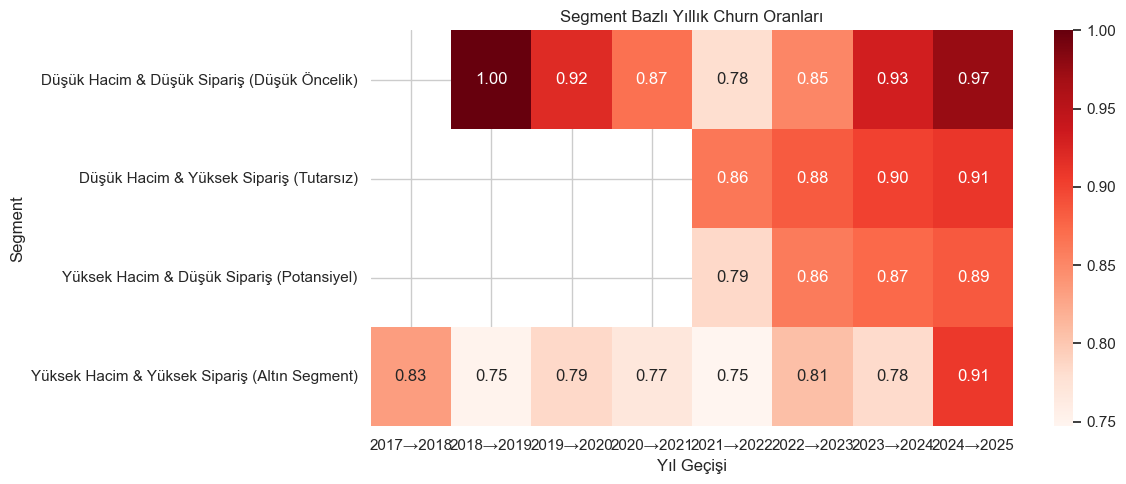

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot tablo: yıllara göre segment churn oranları
pivot_churn = churn_df.pivot(index='segment_kategorisi', columns='yil', values='churn_orani')

plt.figure(figsize=(12, 5))
sns.heatmap(pivot_churn, annot=True, cmap='Reds', fmt='.2f')
plt.title('Segment Bazlı Yıllık Churn Oranları')
plt.ylabel('Segment')
plt.xlabel('Yıl Geçişi')
plt.tight_layout()
plt.savefig("segmentheatmap.png", dpi=300)
plt.show()


"En kritik bulgumuz şu: Hangi segment olursa olsun, churn oranlarımız oldukça yüksek. Tüm segmentlerde yıl sonunda müşterilerimizin en az %75’i tekrar sipariş vermemiş. Bu tablo, sadakat problemini net olarak gözler önüne seriyor."

 Altın Segment'e Bakalım:

"Yüksek hacim ve sık sipariş veren en değerli müşterilerimiz burada yer alıyor. Fakat dikkat edin:
2023’te bu segmentte 1.729 müşteri vardı. 2024’te bunların yalnızca 376’sı tekrar sipariş verdi.
Yani %78’i kaybedildi.
2024’ten 2025’e geçerken bu oran daha da kötüleşiyor: %90’ın üzerinde churn var."

Potansiyel Segment:

"Bu müşteriler büyük hacimli sipariş veriyor ama az sıklıkta. Bu da demek oluyor ki, sipariş verince değer yaratıyorlar ama düzenli değiller.
Churn oranı burada da %85–88 seviyelerinde. Yani bu grup var ama 'uyuyor'."

Tutarsız Segment:

"Bu segment sık sipariş veriyor ama küçük hacimle. Onlar da kayıp veriyor: %86–91 churn arasında gidip geliyor.
Yani biz aslında 'hareketli ama düşük değerli' bir müşteri grubunu da tutamıyoruz."

Düşük Öncelik Segmenti:

"Zaten hacmi ve siparişi düşük olan bu segment neredeyse tamamen kaybediliyor.
2024’ten 2025’e geçerken %97’si gitti. Burada çok büyük bir yatırım yapılmaması gerektiği net."

Stratejik Kapanış Cümlesi:

"Toparlarsak; müşteri kazanmak kadar, hatta daha da önemlisi, elde tutmak.
Bu tablo bize şunu gösteriyor: Elde tutma mekanizmalarımız eksik.
Churn oranlarını düşürmeden sürdürülebilir büyüme sağlanamaz.
Sadakat sistemleri, segment bazlı iletişim ve otomatik takip sistemleri acilen devreye alınmalı."

In [35]:
def detect_language(products):
    products = str(products).lower()
    if "english" in products:
        return "English"
    elif "spanish" in products:
        return "Spanish"
    elif "french" in products:
        return "French"
    elif "arabic" in products:
        return "Arabic"
    elif "chinese" in products:
        return "Chinese"
    elif "vietnamese" in products:
        return "Vietnamese"
    elif "russian" in products:
        return "Russian"
    elif "portuguese" in products:
        return "Portuguese"
    elif "korean" in products:
        return "Korean"
    else:
        return "Unknown"

In [36]:
# Kategori belirleme fonksiyonu
def categorize_product(products):
    products = str(products).lower()

    if "app_card" in products or "app card" in products or "card" in products:
        return "App Cards"
    elif "brochure" in products:
        return "Brochures"
    elif "poster" in products:
        return "Posters"
    elif "wristband" in products:
        return "Wristband"
    elif "magnet" in products:
        return "Magnet"
    else:
        return "Other"




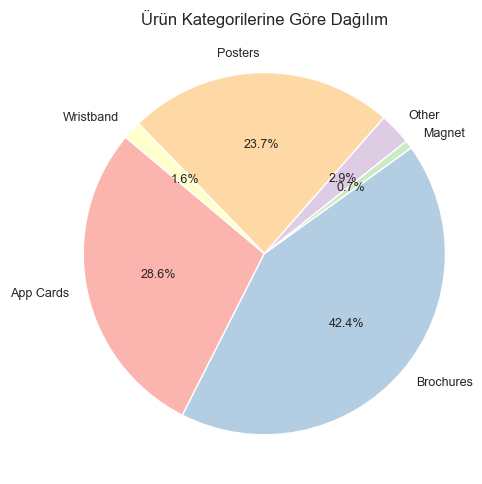

In [57]:
import matplotlib.pyplot as plt

# Ürün kategorilerine göre toplam hacim (örnek veri)
category_dist = df.groupby('product_category')['pieces'].sum()

# Soft pastel renk paleti
colors = plt.cm.Pastel1.colors

# Grafik oluştur
plt.figure(figsize=(5, 5))
plt.pie(
    category_dist,
    labels=category_dist.index,
    autopct='%1.1f%%',
    colors=colors,
    startangle=140,
    textprops={'fontsize': 9}
)

plt.title('Ürün Kategorilerine Göre Dağılım', fontsize=12)
plt.axis('equal')  # Daire şeklinde tutar
plt.tight_layout()
plt.savefig("categorypie.png", dpi=300)
plt.show()


In [ ]:
# Her sipariş için toplam ürün adedi (pieces) hesaplanır
order_quantity = df.groupby('order no')['pieces'].sum()

# Ortalama ürün hacmi: toplam ürün / toplam sipariş
avg_pieces_per_order = order_quantity.mean()

print(f"Sipariş başına ortalama ürün hacmi: {avg_pieces_per_order:.2f} parça")


In [ ]:
# [5.1] Ürün ve dil bazında toplam sipariş hacmi
lang_product = df.groupby(['product_category', 'language'])['pieces'].sum().reset_index()
lang_product = lang_product.sort_values(by='pieces', ascending=False)

display(lang_product.head(10))  # En çok kullanılan ürün-dil çiftleri


In [38]:
# Tesis Tipine göre ortalama sipariş hacmi
avg_by_facility = (
    df.groupby(['facility_type__c', 'order no'])['pieces'].sum()
    .groupby('facility_type__c')
    .mean()
    .reset_index(name='avg_pieces_per_order')
)

display(avg_by_facility)


,facility_type__c,avg_pieces_per_order
0,Birthing Hospital,363.485
1,Family Practice Clinic,190.293
2,Home Visitor,258.124
3,Non-traditional Practice,211.000
4,OBGYN Clinic,338.476
5,Other,482.047
6,Pregnancy Resource Center,363.082
7,Public Health Agency,382.948
8,Urgent Care,238.750
9,WIC Clinic,406.398


In [58]:
# Sipariş hacmini siparişe göre grupla
df['order_year'] = df['order_date__c'].dt.year

# Önce segmentleri tekrar hesapla
segment_table = (
    df.groupby(['facility_type__c', 'customer_account__c'])
    .agg(total_orders=('order no', 'nunique'),
         total_quantity=('pieces', 'sum'))
    .reset_index()
)

segment_table['orders_per_customer'] = segment_table['total_quantity'] / segment_table['total_orders']

# Tesis tipinden segment çıkar
segment_map = df.groupby('facility_type__c').agg(
    total_orders=('order no', 'nunique'),
    total_quantity=('pieces', 'sum'),
    unique_customers=('customer_account__c', 'nunique')
).reset_index()

segment_map['orders_per_customer'] = segment_map['total_quantity'] / segment_map['unique_customers']
x_mean = segment_map['orders_per_customer'].mean()
y_mean = segment_map['total_orders'].mean()

def classify_segment(row):
    if row['orders_per_customer'] >= x_mean and row['total_orders'] >= y_mean:
        return 'Altın Segment'
    elif row['orders_per_customer'] >= x_mean:
        return 'Potansiyel'
    elif row['total_orders'] >= y_mean:
        return 'Tutarsız'
    else:
        return 'Düşük Öncelik'

segment_map['segment'] = segment_map.apply(classify_segment, axis=1)

# Ana df'e segmenti bağla
df = df.merge(segment_map[['facility_type__c', 'segment']], on='facility_type__c', how='left')

# Pivot tablo: yıl x segment
pivot = df.groupby(['order_year', 'segment'])['pieces'].mean().unstack().round(1)

KeyError: 'segment'

In [59]:
# [5.2] Pivot tablo oluştur (heatmap için)
pivot_lang_product = lang_product.pivot(index='product_category', columns='language', values='pieces').fillna(0)


NameError: name 'lang_product' is not defined

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_lang_product, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Ürün ve Dil Bazında Sipariş Hacmi (pieces)")
plt.xlabel("Dil")
plt.ylabel("Ürün Kategorisi")
plt.tight_layout()
plt.savefig("hacim.png", dpi=300)
plt.show()


NameError: name 'pivot_lang_product' is not defined

<Figure size 1200x600 with 0 Axes>

“En yoğun sipariş edilen ürün kategorileri App Cards, Brochures ve Posters’tır. En çok tercih edilen dil açık ara İngilizce olsa da İspanyolca da Brochure ve App Cards'ta güçlü kullanım göstermektedir. Arapça, Fransızca ve Portekizce düşük seviyede ancak hâlâ stratejik önemi olabilir. Lokal içerik stratejileri bu verilere göre şekillendirilebilir.”

In [61]:
region_map = {
    'Northeast': ['CT', 'ME', 'MA', 'NH', 'RI', 'VT', 'NJ', 'NY', 'PA'],
    'Midwest': ['IL', 'IN', 'MI', 'OH', 'WI', 'IA', 'KS', 'MN', 'MO', 'NE', 'ND', 'SD'],
    'South': ['DE', 'FL', 'GA', 'MD', 'NC', 'SC', 'VA', 'DC', 'WV', 'AL', 'KY', 'MS', 'TN', 'AR', 'LA', 'OK', 'TX'],
    'West': ['AZ', 'CO', 'ID', 'MT', 'NV', 'NM', 'UT', 'WY', 'AK', 'CA', 'HI', 'OR', 'WA']
}
state_to_region = {state: region for region, states in region_map.items() for state in states}
df['region'] = df['shipping_state__c'].map(state_to_region)

In [62]:
# [6.1] Müşteri ve bölge bazında toplam sipariş adedi
repeat_orders = df.groupby(['customer_account__c', 'region']).size().reset_index(name='ordercount')


In [63]:
# [6.2] Tekrar eden müşterileri filtrele
repeat_orders = repeat_orders[repeat_orders['ordercount'] > 1]


In [64]:
# [6.3] Her bölgede kaç müşteri tekrar sipariş vermiş?
region_repeat_counts = repeat_orders.groupby('region').size().reset_index(name='repeatcustomercount')
region_repeat_counts = region_repeat_counts.sort_values(by='repeatcustomercount', ascending=False)


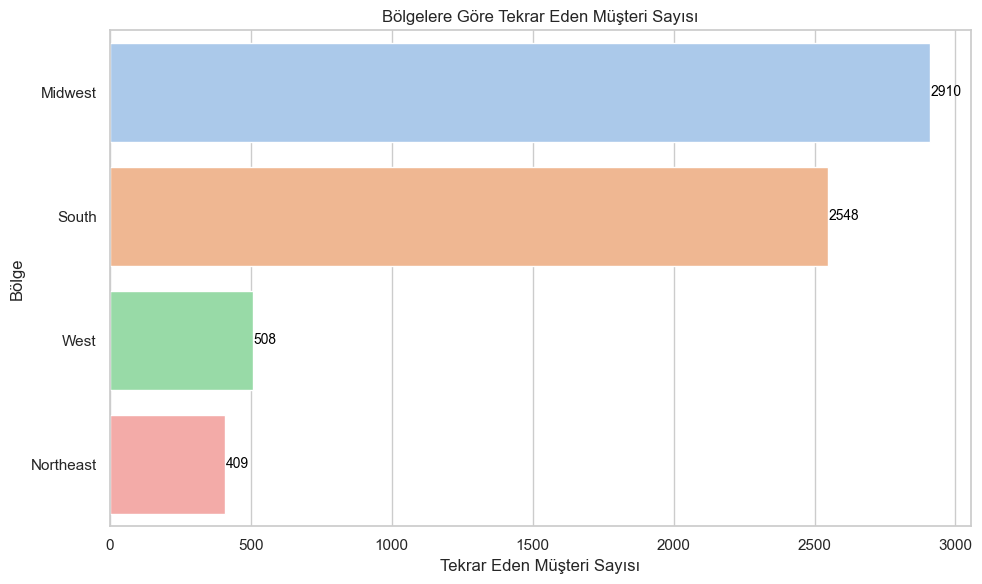

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

barplot = sns.barplot(
    x='repeatcustomercount',
    y='region',
    data=region_repeat_counts,
    palette='pastel'
)

# Etiketleri çubukların sonuna ekle
for p in barplot.patches:
    width = p.get_width()
    y_pos = p.get_y() + p.get_height() / 2
    barplot.annotate(f'{int(width)}', (width + 2, y_pos), va='center', fontsize=10, color='black')

plt.title('Bölgelere Göre Tekrar Eden Müşteri Sayısı')
plt.xlabel('Tekrar Eden Müşteri Sayısı')
plt.ylabel('Bölge')
plt.tight_layout()
plt.savefig("regioncustomer.png", dpi=300)
plt.show()


“Tekrar sipariş davranışı bölgelere göre farklılık göstermektedir. Özellikle Midwest ve South bölgeleri yüksek sadakat göstermiştir. Bu bölgeler hem pazarlama yatırımı hem de lojistik verimlilik açısından öncelikli olabilir. Düşük sadakat görülen bölgelerde farkındalık veya erişim sorunları araştırılmalıdır.”

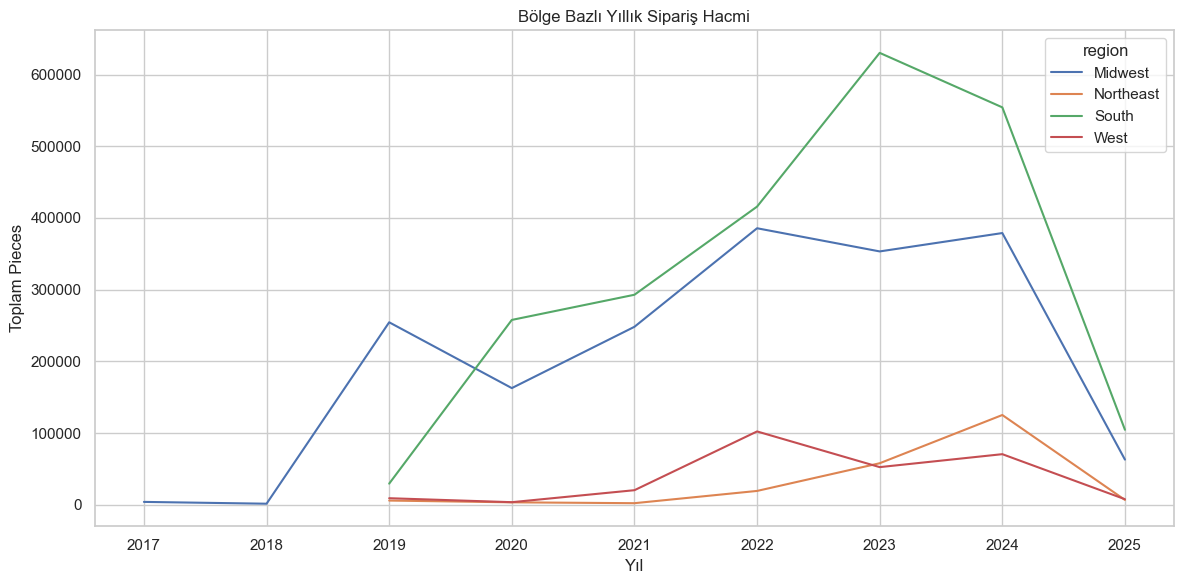

In [47]:
region_year = df.groupby(['region', 'order_year'])['pieces'].sum().unstack()
region_year.T.plot(figsize=(12, 6), title='Bölge Bazlı Yıllık Sipariş Hacmi')
plt.xlabel('Yıl')
plt.ylabel('Toplam Pieces')
plt.grid(True)
plt.tight_layout()
plt.savefig("yearregion.png", dpi=300)
plt.show()

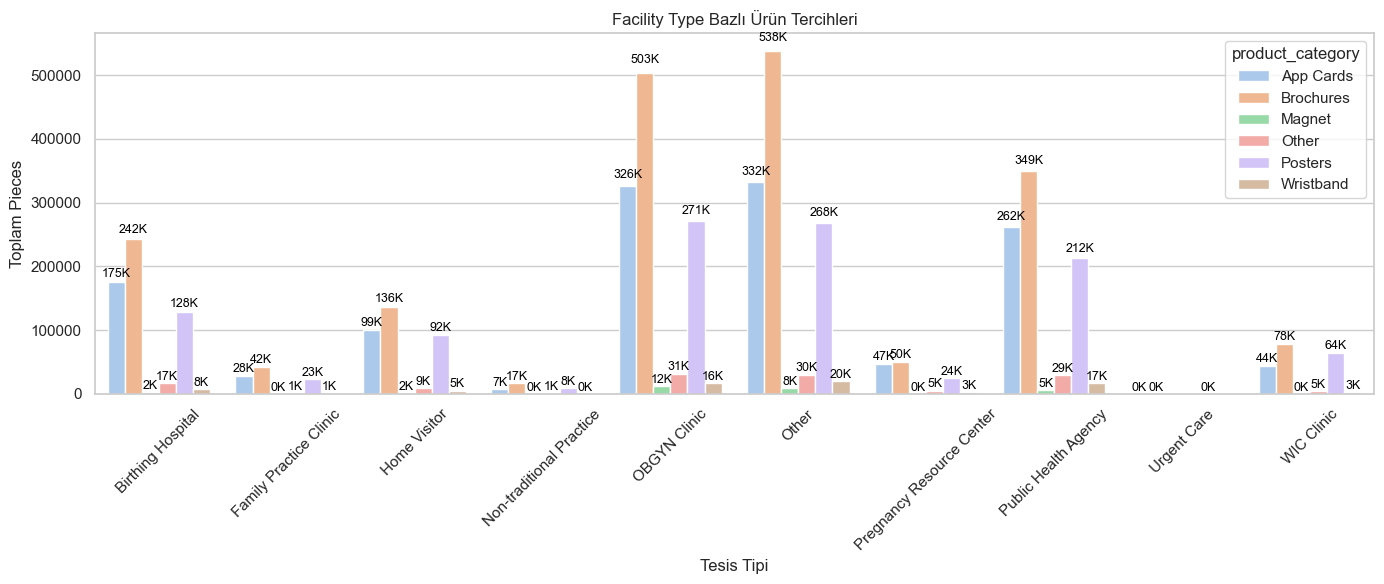

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# Örnek veri (kendi df'inle değiştirebilirsin)
segment_product = (
    df.groupby(['facility_type__c', 'product_category'])['pieces']
    .sum()
    .reset_index()
)

# Grafik
plt.figure(figsize=(14, 6))
sns.set(style="whitegrid")
palette = sns.color_palette("pastel")

bar = sns.barplot(
    data=segment_product,
    x='facility_type__c',
    y='pieces',
    hue='product_category',
    palette=palette
)

# Etiketleri 3 haneli (örn. 12K), yatay ve çubuğun üstüne yerleştir
for container in bar.containers:
    for bar_rect in container:
        height = bar_rect.get_height()
        if height > 0:
            short_label = f'{int(height / 1000)}K'
            bar.axes.text(
                bar_rect.get_x() + bar_rect.get_width() / 2,
                height + (0.02 * height),
                short_label,
                ha='center',
                va='bottom',
                fontsize=9,
                rotation=0,
                color='black'
            )

plt.title('Facility Type Bazlı Ürün Tercihleri')
plt.ylabel('Toplam Pieces')
plt.xlabel('Tesis Tipi')
plt.xticks(rotation=45)
plt.savefig("facilitytypeproduct.png", dpi=300)
plt.tight_layout()
plt.show()


In [ ]:
# [1] Şehir bazında toplam sipariş, ürün hacmi ve müşteri sayısı
city_summary = df.groupby('shipping_city__c').agg(
    total_orders=('order no', 'nunique'),
    total_pieces=('pieces', 'sum'),
    unique_customers=('customer_account__c', 'nunique')
).reset_index()

# Müşteri başına ortalama sipariş hacmi
city_summary['orders_per_customer'] = city_summary['total_pieces'] / city_summary['unique_customers']


In [ ]:
# [2] Tekrar sipariş veren müşterileri şehir özelinde belirle
city_repeat = df.groupby(['customer_account__c', 'shipping_city__c'])['order no'].nunique().reset_index(name='order_count')
city_repeat['is_repeat'] = city_repeat['order_count'] > 1

# [3] Her şehir için tekrar eden müşteri oranı
city_repeat_rate = city_repeat.groupby('shipping_city__c')['is_repeat'].mean().reset_index(name='repeat_rate')

# [4] Birleştir
city_summary = city_summary.merge(city_repeat_rate, on='shipping_city__c')


In [49]:
# [5] En yüksek sipariş sayısına göre sıralama
top_cities = city_summary.sort_values(by='total_orders', ascending=False).head(10)
display(top_cities)


NameError: name 'city_summary' is not defined

Bu tablo, en çok sipariş veren şehirleri müşteri sayısı, sipariş hacmi ve sadakat oranlarıyla birlikte özetliyor.
En dikkat çekici şehir, Columbus. Toplamda 163 siparişle bu listedeki en yüksek sipariş sayısına sahip şehir.
Hem müşteri sayısı hem de sipariş hacmiyle öne çıkıyor. Ancak sadakat oranı %31 seviyesinde, yani her 3 müşteriden sadece biri tekrar sipariş veriyor."

"Columbus’un ardından Des Moines, Wichita, Cincinnati ve Indianapolis gibi şehirler geliyor.
Bazıları hacim açısından güçlü (örneğin Cincinnati, yüksek parça hacmiyle öne çıkıyor), bazıları ise Montgomery gibi az müşteriye rağmen hem yüksek hacim hem de en güçlü sadakat oranını (%41) gösteriyor."
Genel Değerlendirme:

"Bu tablo bize sadece nerede yoğunluk olduğunu değil, nerede kaliteli ve sürdürülebilir müşteri ilişkisi kurduğumuzu da gösteriyor.
Sadakat oranı ile hacmin birlikte yüksek olduğu şehirler öncelikli yatırım alanları olmalı.
Bağ kurulamamış ama hacim potansiyeli olan şehirlerde ise müşteri ilişkileri ve tekrar sipariş teşvikleri devreye alınmalı."

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

# Sipariş sayısı grafiği
bar = sns.barplot(x='total_orders', y='shipping_city__c', data=top_cities, palette='pastel')

# Etiket ekle
for p in bar.patches:
    width = p.get_width()
    plt.text(width + 5, p.get_y() + p.get_height() / 2, int(width), va='center')

plt.title('En Çok Sipariş Veren İlk 10 Şehir')
plt.xlabel('Toplam Sipariş Sayısı')
plt.ylabel('Şehir')
plt.tight_layout()
plt.savefig("top10citysum.png", dpi=300)
plt.show()


NameError: name 'top_cities' is not defined

<Figure size 1200x600 with 0 Axes>

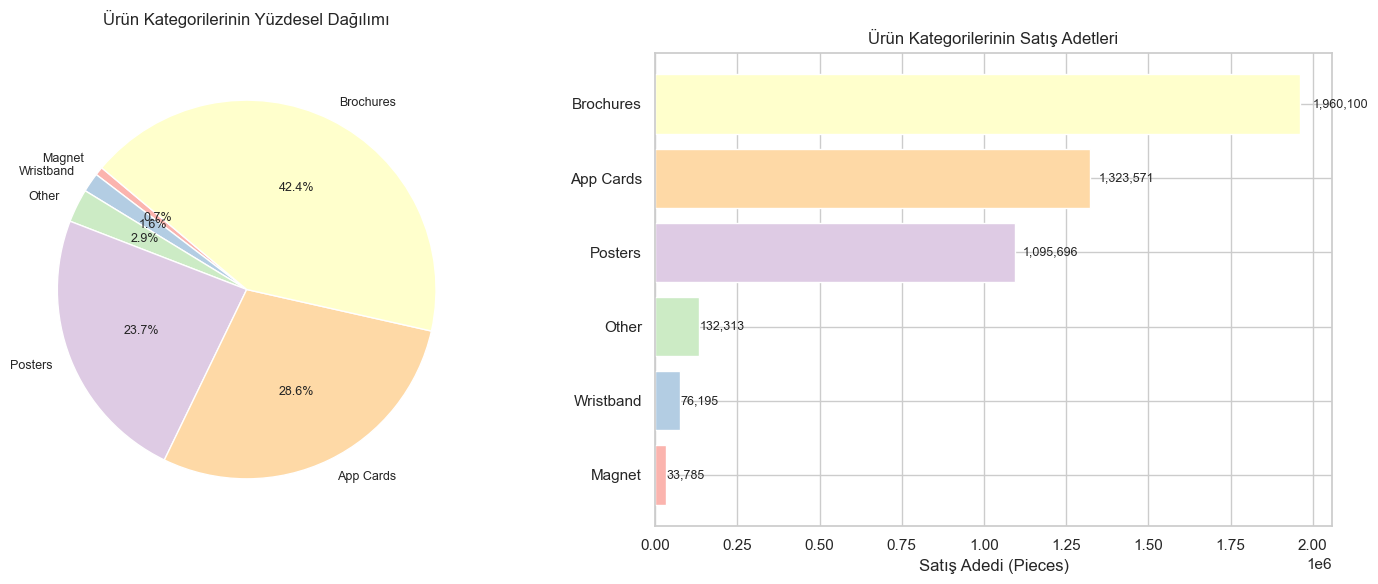

In [55]:


# Ürün kategorilerine göre toplam hacim 
category_dist = df.groupby('product_category')['pieces'].sum().sort_values(ascending=True)

# İki alt grafik oluştur
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 1. Grafik: Pasta dilimi (yüzdesel dağılım)
colors = plt.cm.Pastel1.colors
ax1.pie(
    category_dist,
    labels=category_dist.index,
    autopct='%1.1f%%',
    colors=colors,
    startangle=140,
    textprops={'fontsize': 9}
)
ax1.set_title('Ürün Kategorilerinin Yüzdesel Dağılımı', pad=20)

# 2. Grafik: Yatay bar (satış adetleri)
bars = ax2.barh(
    y=category_dist.index,
    width=category_dist.values,
    color=colors[:len(category_dist)]
)

# Bar değerlerini ekle (düzeltilmiş version)
for bar in bars:
    width = bar.get_width()
    ax2.text(
        width + width*0.02,  # Değerin konumu için küçük bir offset
        bar.get_y() + bar.get_height()/2,
        f'{int(width):,}',
        va='center',
        ha='left',
        fontsize=9
    )

ax2.set_title('Ürün Kategorilerinin Satış Adetleri')
ax2.set_xlabel('Satış Adedi (Pieces)')

plt.tight_layout()
plt.savefig("category_distribution.png", dpi=300, bbox_inches='tight')
plt.show()


#	Tespit
1	Sipariş hacmi 2019 sonrası hızla büyüdü, ancak 2025 incelenmeli henüz tamamlanmadı.
2	Altın Segment dahil tüm segmentlerde yıllık müşteri kaybı (churn) %75’in üzerinde; en değerli müşteriler bile tutulamıyor.
3	İngilizce ve İspanyolca dillerinde Brochure ve App Cards gibi ürünlere yoğun talep var.
4	Tekrar eden sipariş davranışı bazı bölgelerde yüksek (örneğin X, Y); sadakat farklılaşıyor.
5	2025 yılının tüm verileri henüz oluşmadığı için büyüme değerlendirmelerinde temkinli olunmalı.

Sadakati Güçlendirin:
Özellikle Altın Segment için özel teklifler, kampanyalar, sadakat puanı sistemi ve kişisel müşteri temsilcileri önerilir.

Potansiyel Segmenti Aktive Edin:
Büyük hacim sipariş eden ama seyrek sipariş veren müşterilere otomatik sipariş programları, "2 ayda 1" avantajları sunulabilir.

Churn'e Erken Müdahale:
Son 12 ayda aktif olmayan ama geçmişte yüksek sipariş vermiş müşteriler için otomatik uyarı sistemi ve kurtarma e-mail’leri önerilir.

Bölge ve Dil Bazlı Hedefleme:
Sadakat oranı yüksek bölgelerde pazarlama yoğunlaştırılmalı; düşük olanlara özel tanıtımlar yapılmalı.
İngilizce ve İspanyolca içerikler ana odak olmalı, Arapça ve Fransızca küçük segmentleri destekleyecek şekilde yer verilmeli.

2025’e Özel Veri Takibi:
2025 henüz tamamlanmamış olduğundan, bu yılın performansı aylık olarak canlı izlenmeli ve yıl tamamlandığında yeniden değerlendirilmeli.

“Elimizdeki bu analizler, sadece geçmişi değil geleceği yönetme fırsatı sunuyor. Segment bazlı yaklaşım, churn kontrolü ve sadakat stratejileri ile büyümeyi sürdürülebilir hale getirebiliriz.”

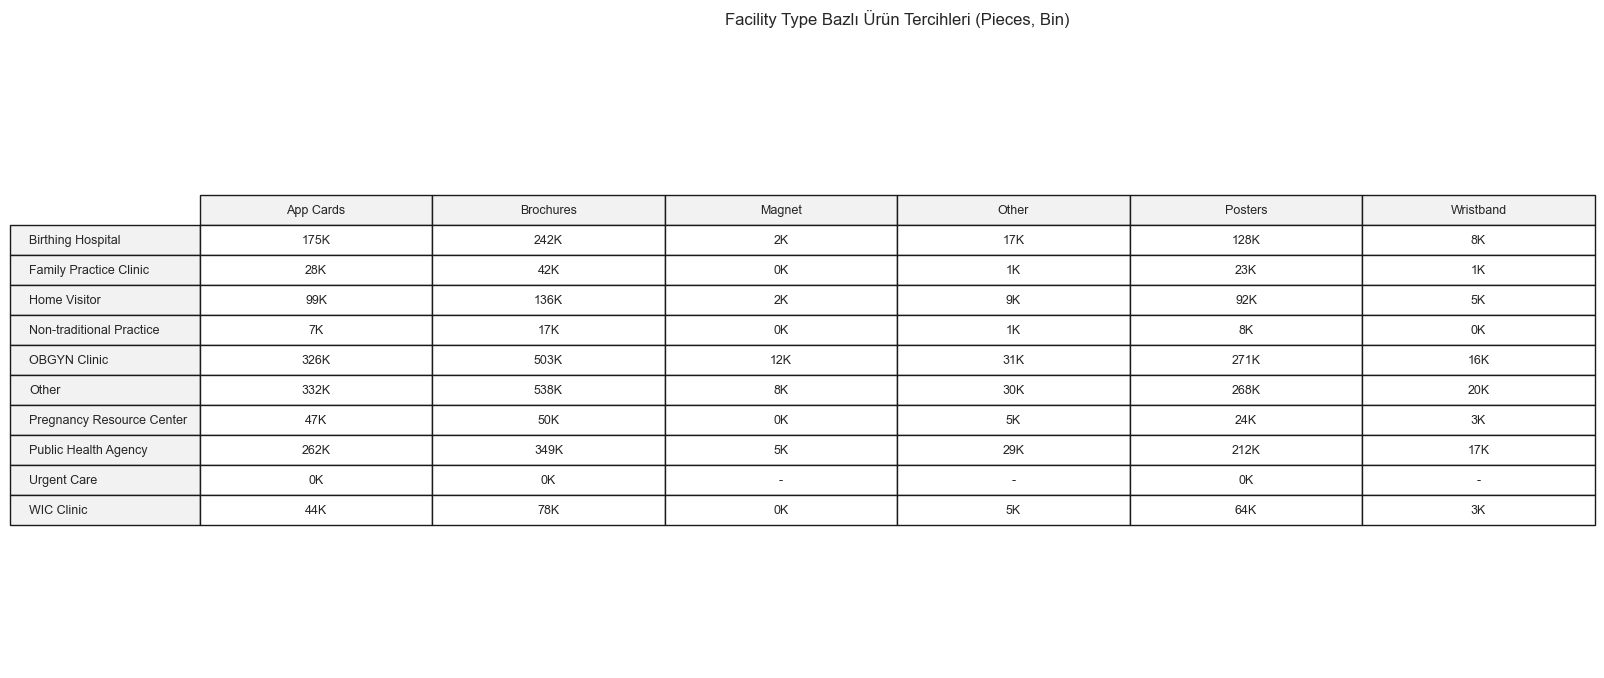

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Veriyi hazırla
segment_product = (
    df.groupby(['facility_type__c', 'product_category'])['pieces']
    .sum()
    .reset_index()
)

# Pivot tablo oluştur
pivot_table = segment_product.pivot(
    index='facility_type__c',
    columns='product_category',
    values='pieces'
).fillna(0)

# Değerleri K formatına çevir (örn: 1000 -> 1K)
formatted_data = pivot_table.applymap(lambda x: f'{int(x/1000)}K' if x > 0 else '-')

# Figür ve axis oluştur
fig, ax = plt.subplots(figsize=(15, 8))
ax.axis('off')

# Tablo oluştur
table = ax.table(
    cellText=formatted_data.values,
    rowLabels=formatted_data.index,
    colLabels=formatted_data.columns,
    cellLoc='center',
    loc='center',
    colColours=['#f2f2f2']*len(formatted_data.columns),
    rowColours=['#f2f2f2']*len(formatted_data.index)
)

# Tablo stilini ayarla
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.8)  # Tablo hücrelerinin boyutunu ayarla

# Başlık ekle
plt.title('Facility Type Bazlı Ürün Tercihleri (Pieces, Bin)', pad=20, fontsize=12)

# Tabloyu kaydet
plt.savefig("facilitytypeproduct_table.png", 
            dpi=300, 
            bbox_inches='tight',
            pad_inches=0.5)
plt.show()

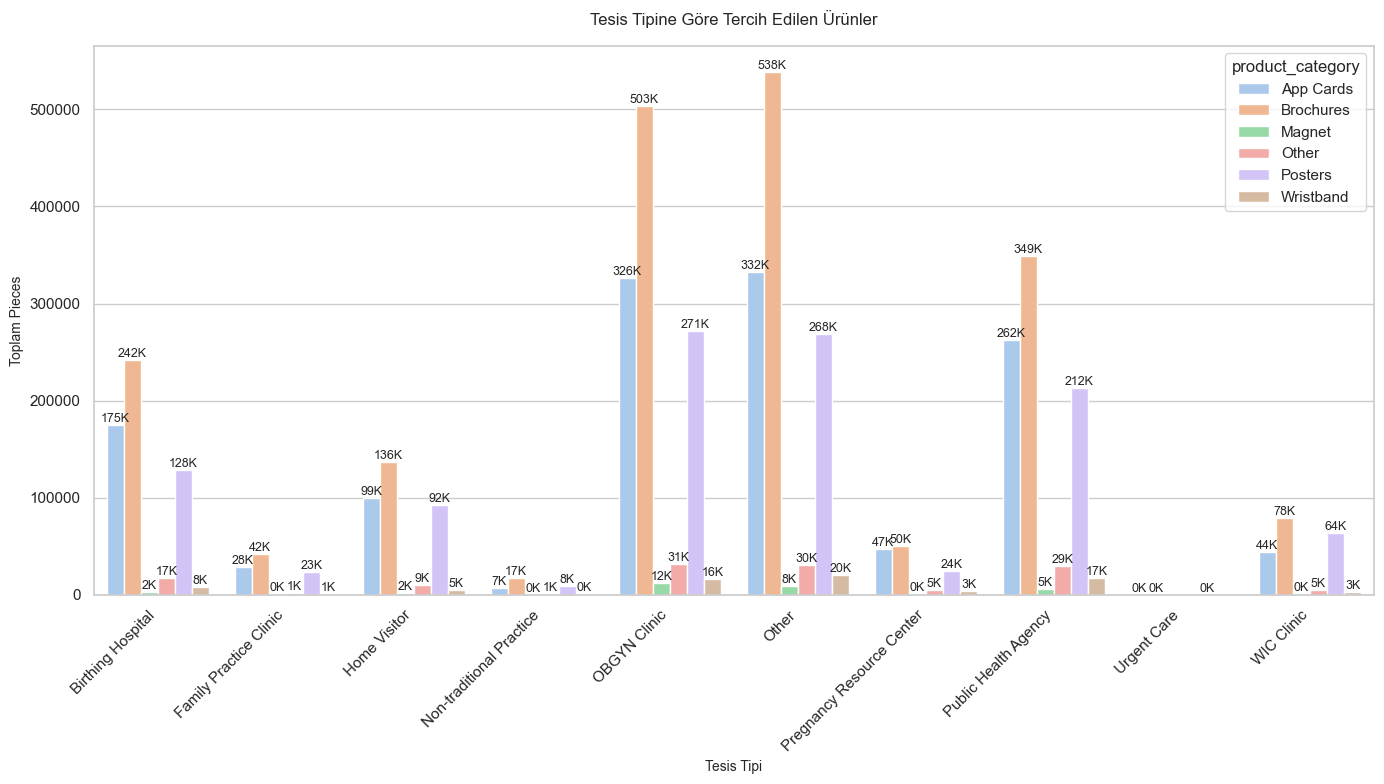

In [68]:
# Import gerekli kütüphaneleri
import matplotlib.pyplot as plt
import seaborn as sns

# Tesis tipi ve ürün kategorisine göre toplam pieces'ları grupla
segment_product = (
    df.groupby(['facility_type__c', 'product_category'])['pieces']
    .sum()
    .reset_index()
)

# Grafiği oluştur
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")
palette = sns.color_palette("pastel")

# Çubuk grafiği çiz
bar = sns.barplot(
    data=segment_product,
    x='facility_type__c',
    y='pieces',
    hue='product_category',
    palette=palette
)

# Grafik başlığı ve eksen etiketleri
plt.title('Tesis Tipine Göre Tercih Edilen Ürünler', fontsize=12, pad=15)
plt.xlabel('Tesis Tipi', fontsize=10)
plt.ylabel('Toplam Pieces', fontsize=10)

# X ekseni etiketlerini 45 derece döndür
plt.xticks(rotation=45, ha='right')

# Etiketleri çubuklara ekle (bin cinsinden)
for container in bar.containers:
    for bar_rect in container:
        height = bar_rect.get_height()
        if height > 0:
            short_label = f'{int(height/1000)}K'
            bar.axes.text(
                bar_rect.get_x() + bar_rect.get_width()/2,
                height,
                short_label,
                ha='center',
                va='bottom',
                fontsize=9
            )

# Grafik düzenini ayarla
plt.tight_layout()

# Grafiği kaydet ve göster
plt.savefig("facility_product_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

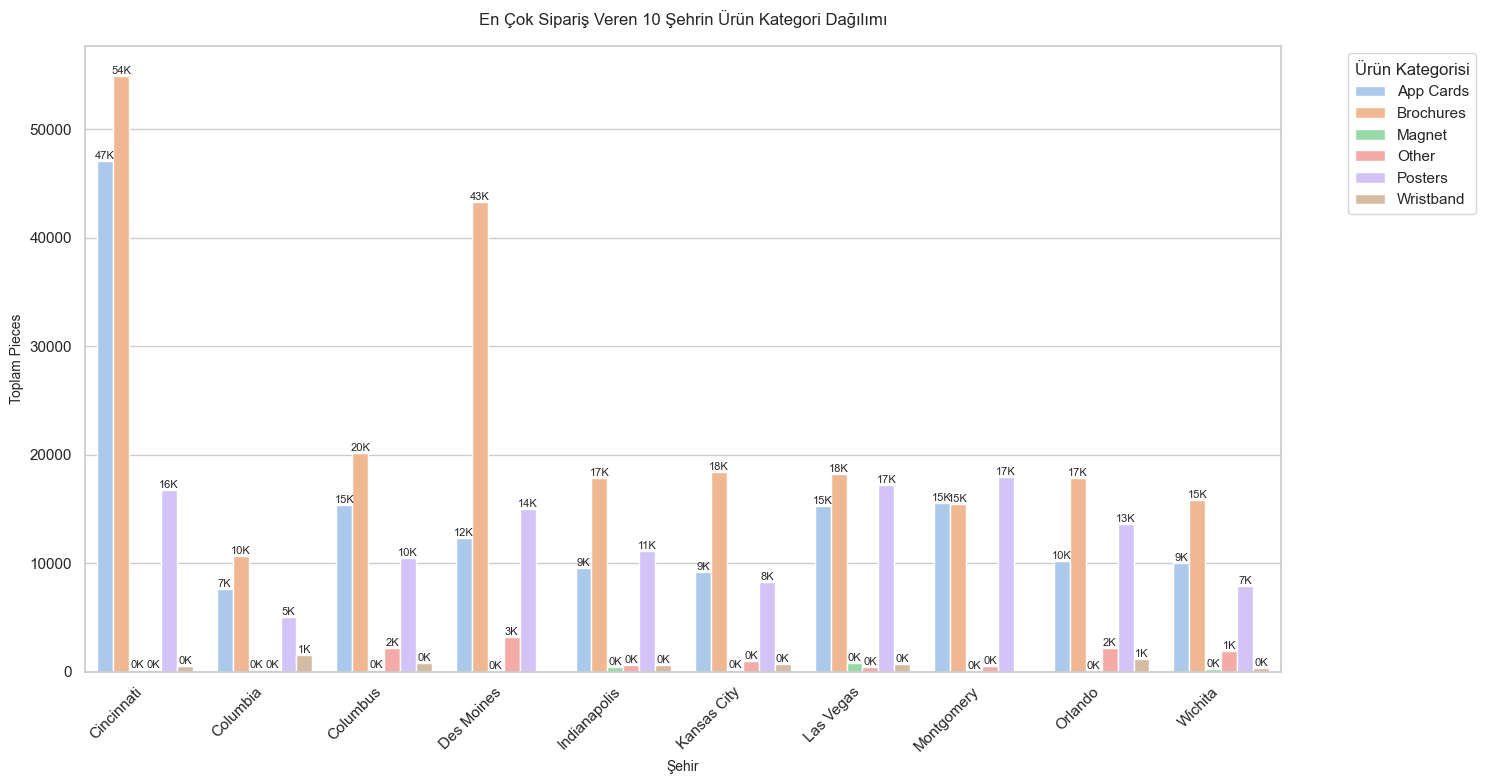

In [69]:
# Top 10 şehir ve ürün kategorilerine göre analiz
# En çok sipariş veren 10 şehri belirle
top_10_cities = df.groupby('shipping_city__c')['order no'].nunique().nlargest(10).index

# Top 10 şehir için ürün kategori dağılımı
city_category_dist = (df[df['shipping_city__c'].isin(top_10_cities)]
                     .groupby(['shipping_city__c', 'product_category'])['pieces']
                     .sum()
                     .reset_index())

# Görselleştirme
plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")

# Çubuk grafiği oluştur
bar = sns.barplot(
    data=city_category_dist,
    x='shipping_city__c',
    y='pieces',
    hue='product_category',
    palette='pastel'
)

# Grafik başlığı ve eksen etiketleri
plt.title('En Çok Sipariş Veren 10 Şehrin Ürün Kategori Dağılımı', fontsize=12, pad=15)
plt.xlabel('Şehir', fontsize=10)
plt.ylabel('Toplam Pieces', fontsize=10)

# X ekseni etiketlerini 45 derece döndür
plt.xticks(rotation=45, ha='right')

# Her çubuk için değer etiketi ekle (bin cinsinden)
for container in bar.containers:
    for bar_rect in container:
        height = bar_rect.get_height()
        if height > 0:
            short_label = f'{int(height/1000)}K'
            bar.axes.text(
                bar_rect.get_x() + bar_rect.get_width()/2,
                height,
                short_label,
                ha='center',
                va='bottom',
                fontsize=8
            )

# Grafik düzenini ayarla
plt.legend(title='Ürün Kategorisi', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Grafiği kaydet
plt.savefig("top10_cities_product_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

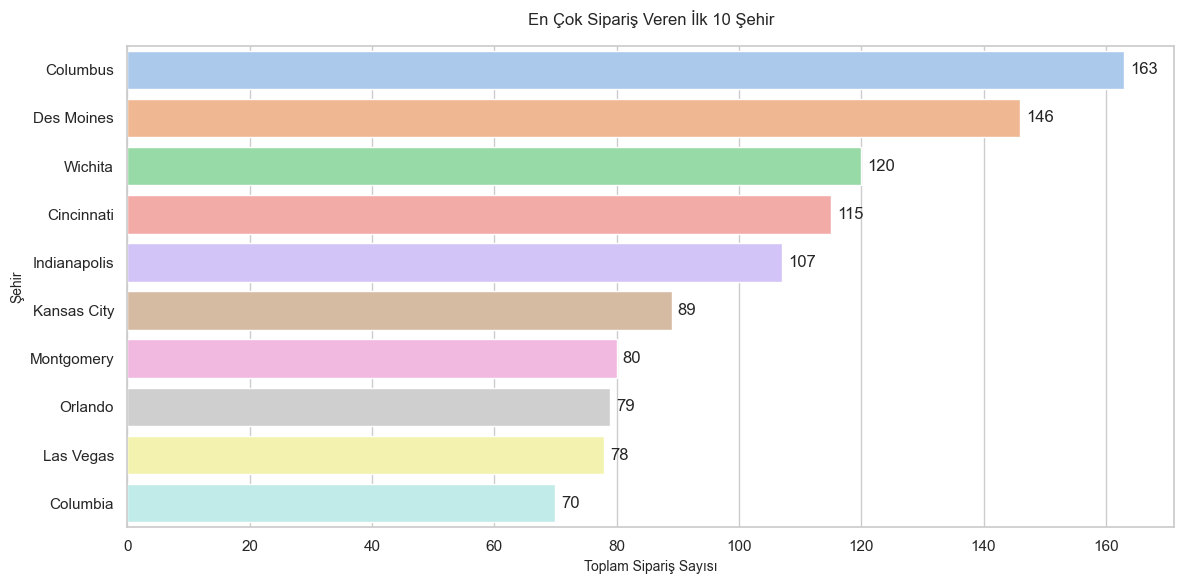

In [70]:
# Şehirlere göre toplam sipariş sayısını hesapla
city_orders = df.groupby('shipping_city__c')['order no'].nunique().reset_index()
city_orders.columns = ['city', 'total_orders']

# En çok sipariş veren ilk 10 şehri seç
top_10_cities = city_orders.nlargest(10, 'total_orders')

# Görselleştirme
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Çubuk grafiği oluştur
bar = sns.barplot(
    data=top_10_cities,
    x='total_orders',
    y='city',
    palette='pastel'
)

# Başlık ve eksen etiketleri
plt.title('En Çok Sipariş Veren İlk 10 Şehir', fontsize=12, pad=15)
plt.xlabel('Toplam Sipariş Sayısı', fontsize=10)
plt.ylabel('Şehir', fontsize=10)

# Değerleri çubukların yanına ekle
for i in bar.patches:
    width = i.get_width()
    plt.text(width+1, i.get_y() + i.get_height()/2, 
             f'{int(width)}',
             ha='left', va='center')

# Grafik düzenini ayarla
plt.tight_layout()

# Grafiği kaydet ve göster
plt.savefig("top_10_cities_orders.png", dpi=300, bbox_inches='tight')
plt.show()